# dida Task
## Predicting rooftop shape using satellite images
This file is intended as an intuitive and visually more appealling presentation of my submission, than the source code itself. Nevertheless, the source code should functionally (no pun intended) cover the same aspects and match the readability of this notebook. 

The main folder contains a requirements YAML file for conda users and a requirements.txt for pip users which has all the necessary packages listed needed to run this notebook, as well as the source code. The code was executed using a laptop with 32 GB RAM, an i7-11850H processor and a NVIDIA T1200 Laptop GPU (around 1 GB). 

At the end of the notebook I also mention additional points I would've liked to implement and test, however, as I work more than full-time, time constraints prohibited me from doing so. In my opinion this task was quite a bit of fun and I also learned a lot. Without further ado let us start.

In [1]:
import sys
sys.path.append('./src') # Add the src folder to the search path for modules

from data_load import *
from model_u_net import *
from train_helpers import *
from utils import *

## 1. Exploratory Data Analysis & Problem Statement
Before we start selecting and training a model, we have to formalize our problem statement, as well as performing some exploratory data analysis to verify data integrity and identify any unusual patterns. 

The problem in this task is to correctly predict rooftops in satellite images. Formally, this is an image segmentation task, where instead of classifying a single object in a picture or multiple objects in an image, we classify pixels in the images as belonging to the target class or not (binary segmentation). 

I've decided to use PyTorch for the implementation, as this is the library I'm most familiar with. As such we will start by creating a custom rooftop dataset class, inheriting from the Dataset class from PyTorch. Since there are only 55 images in total, I split the data manually in train, validation, and test set and stored the images and the labels (if they exist) in seperate folders. 

In [2]:
# Instantiate class from src
data_train = rooftops_dataset(data_dir=".\\data\\train")
data_val = rooftops_dataset(data_dir=".\\data\\validation")
data_test = rooftops_dataset(data_dir=".\\data\\test", test_set=True)

Let us iterate through the images of the train and validation set, plotting labels side by side to see if we notice anything unusual.

Image size is:  (256, 256)
Label size is:  (256, 256)


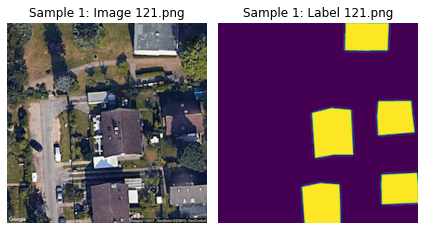

Image size is:  (256, 256)
Label size is:  (256, 256)


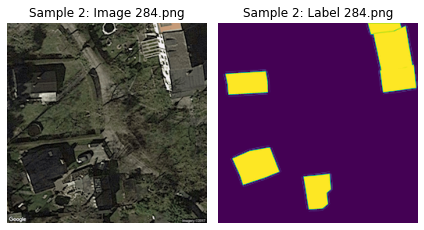

Image size is:  (256, 256)
Label size is:  (256, 256)


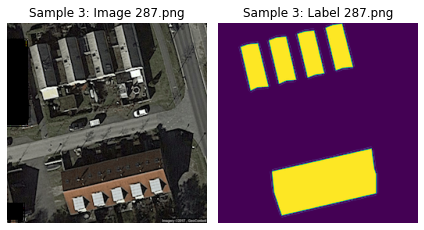

Image size is:  (256, 256)
Label size is:  (256, 256)


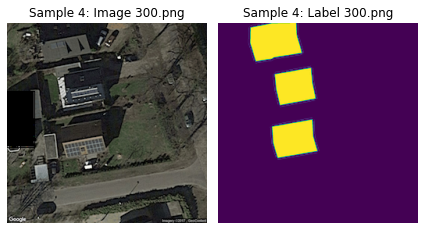

Image size is:  (256, 256)
Label size is:  (256, 256)


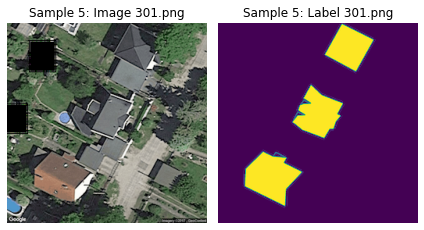

Image size is:  (256, 256)
Label size is:  (256, 256)


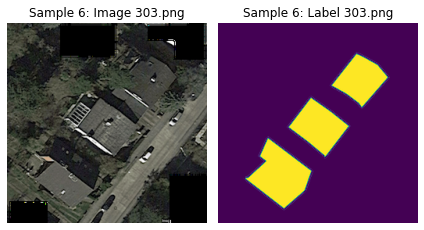

Image size is:  (256, 256)
Label size is:  (256, 256)


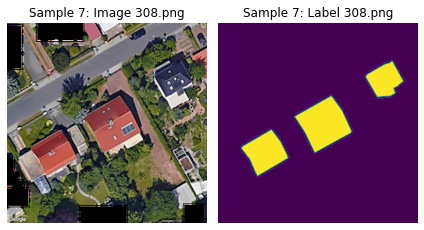

Image size is:  (256, 256)
Label size is:  (256, 256)


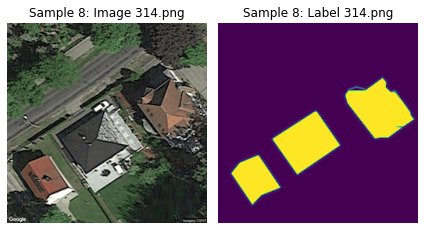

Image size is:  (256, 256)
Label size is:  (256, 256)


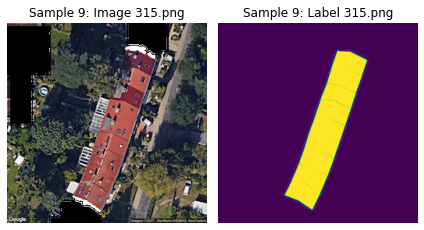

Image size is:  (256, 256)
Label size is:  (256, 256)


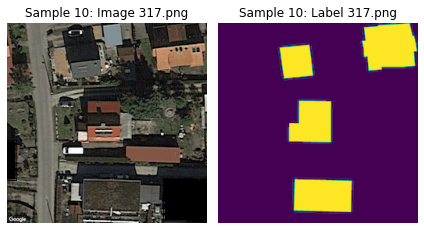

Image size is:  (256, 256)
Label size is:  (256, 256)


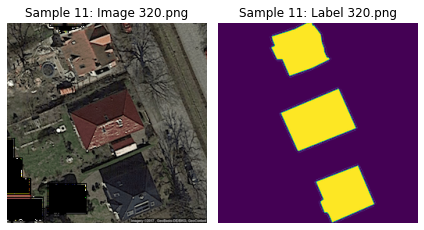

Image size is:  (256, 256)
Label size is:  (256, 256)


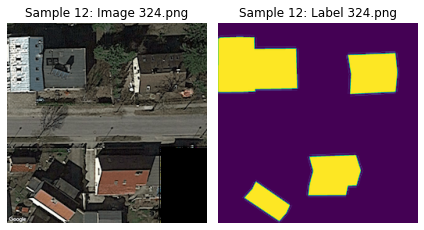

Image size is:  (256, 256)
Label size is:  (256, 256)


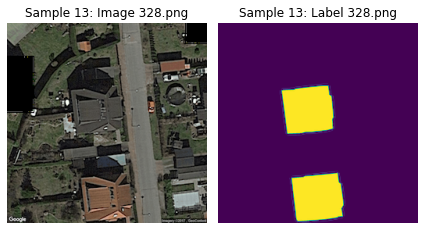

Image size is:  (256, 256)
Label size is:  (256, 256)


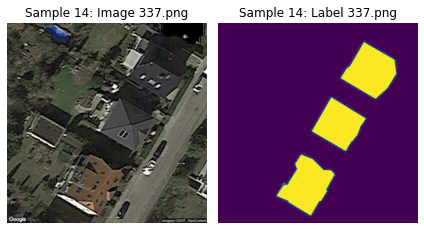

Image size is:  (256, 256)
Label size is:  (256, 256)


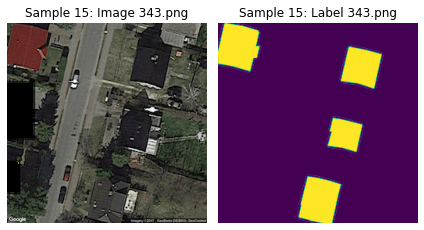

Image size is:  (256, 256)
Label size is:  (256, 256)


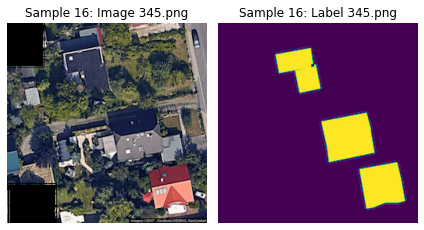

Image size is:  (256, 256)
Label size is:  (256, 256)


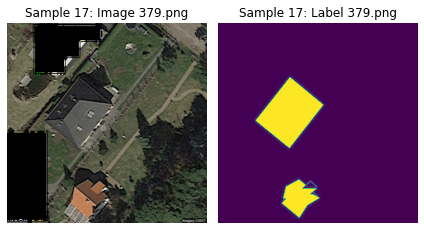

Image size is:  (256, 256)
Label size is:  (256, 256)


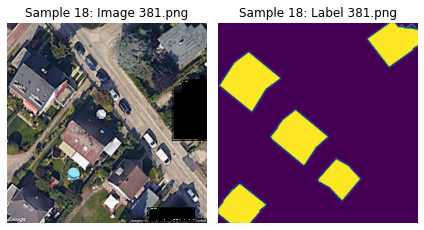

Image size is:  (256, 256)
Label size is:  (256, 256)


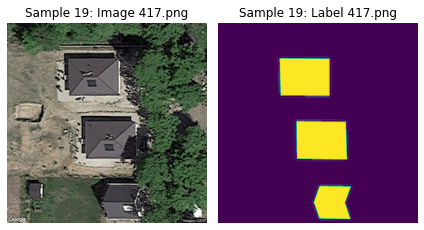

Image size is:  (256, 256)
Label size is:  (256, 256)


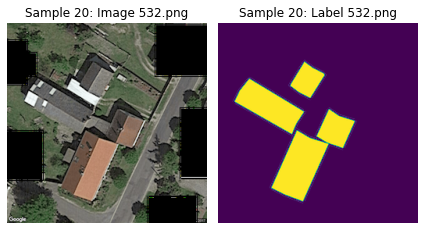

In [11]:
    # Train set
    for i, (sample, name) in enumerate(zip(data_train, data_train.filenames), start=1):
        print("Image size is: ", sample["image"].size)
        print("Label size is: ", sample["label"].size)

        # Reswap axis for plotting
        fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
        plt.interactive(False)
        ax1.imshow(sample["image"])
        ax1.axis("off")
        ax1.set_title(f"Sample {i}: Image {name}")

        ax2.imshow(sample["label"])
        ax2.axis("off")
        ax2.set_title(f"Sample {i}: Label {name}")

        plt.tight_layout()
        plt.show()

Image size is:  (256, 256)
Label size is:  (256, 256)


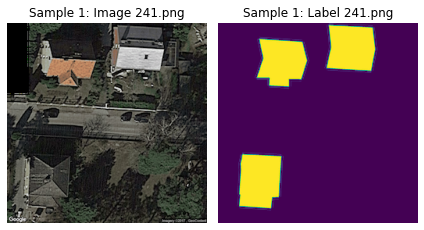

Image size is:  (256, 256)
Label size is:  (256, 256)


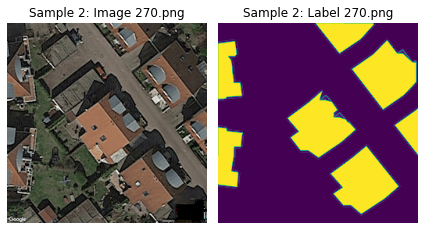

Image size is:  (256, 256)
Label size is:  (256, 256)


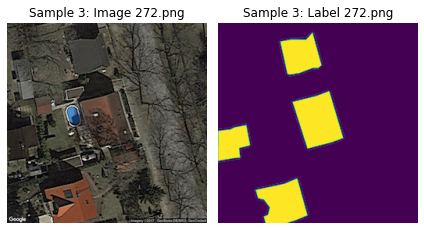

Image size is:  (256, 256)
Label size is:  (256, 256)


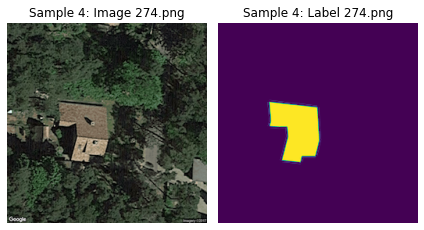

In [10]:
    # Validation set
    for i, (sample, name) in enumerate(zip(data_val, data_val.filenames), start=1):
        print("Image size is: ", sample["image"].size)
        print("Label size is: ", sample["label"].size)

        # Reswap axis for plotting
        fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
        plt.interactive(False)
        ax1.imshow(sample["image"])
        ax1.axis("off")
        ax1.set_title(f"Sample {i}: Image {name}")

        ax2.imshow(sample["label"])
        ax2.axis("off")
        ax2.set_title(f"Sample {i}: Label {name}")

        plt.tight_layout()
        plt.show()

Image size is:  (256, 256)


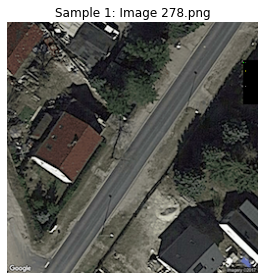

Image size is:  (256, 256)


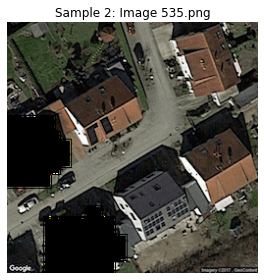

Image size is:  (256, 256)


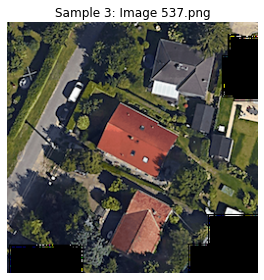

Image size is:  (256, 256)


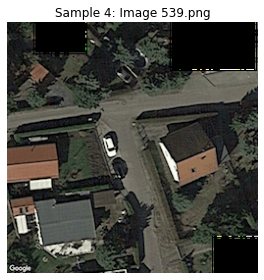

Image size is:  (256, 256)


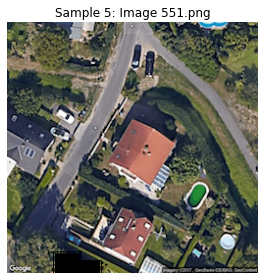

Image size is:  (256, 256)


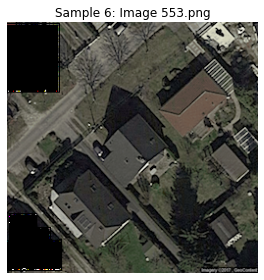

In [9]:
    # Test set
    for i, (sample, name) in enumerate(zip(data_test, data_test.filenames), start=1):
        print("Image size is: ", sample["image"].size)

        # Reswap axis for plotting
        fig, ax1 = plt.subplots(1, 1, sharey=True)
        plt.interactive(False)
        ax1.imshow(sample["image"])
        ax1.axis("off")
        ax1.set_title(f"Sample {i}: Image {name}")
        plt.tight_layout()
        plt.show()

We notice three things:
1. For some images, in particular 379, 327, and 274, most of the pixels in the image do not belong to the rooftop class;
2. The sizes of the images are identical (256 x 256), which makes our live easier when training our model;
3. For many images we see black boxes that were probably drawn due to privacy reasons. These might be problematic, as a model with high capacity could just overfit and use those boxes to identify specific rooftop patterns found in the training data, see also Clever Hans predictor https://www.nature.com/articles/s41467-019-08987-4. 

Two other things we noticed when we created the data set class:
1. The images are stored in the CMYK format and the labels are not loaded in greyscale format. The class converts the images to RGB, virtually any image analysis nowadays uses the RGB color space. This also should not make a difference for a human to predict rooftops, so we would require the same from any model. Additonally, we convert the labels to greyscale;
2. For the image 278 (shown here in the test set) we have noticed that the corresponding label is actually the label of 270. We devised three strategies to deal with this

a.) Ignore this fact and just feed the image with the wrong label into the model (naive approach);\
b.) Drawing a label by our self for this image;\
c.) Move this image to the test set and handle it as such.

We will compare each strategy later, although we suspect, that either b.) or c.) are the most promising one, as a.) bears the risk of model confusion. 

Let us now move forward to model selection.

## 2. Model Selection and Design
In this section we describe the model selection process and also the design of the model. We decided to use a U-Net architecture, as originally proposed in https://arxiv.org/abs/1505.04597 for biomedical image segmentation. The reason for this are threefold:
1. At the original time of release, this architecture proved to be groundbreaking and set new state-of-the-art results in (biomedical) image segmentation. Although recent advancement in image segmentation models improved on these results it could still be considers as a solid baseline model that should perform at least better than other, more general architectures;
2. The design is straightforward and also the model size (in term of memory and parameters) easy to handle (compared to current state-of-the-art architectures);
3. The U-Net architecture yields a relatively good (training) performance even with relatively few sample images.

Of course their would have been many alternatives, up to transfer-learning a state-of-the-art pretrained model, such as Swin (https://arxiv.org/abs/2103.14030) a transformer model (which are now ubiquitous in deep learning). But given the reasons above, time constraints, and the desire to code the model from the ground up and see how good it performs as a baseline / straightforward solution, we opted for the use of the U-Net architecture.

The U-Net architecture can be understood as a encoder / decoder convolutional network with the additional trait, that it allows at each encoding stage for not only a contracting but also an expanding path, where the output of the encoder layer is used as input in the corresponding decoder layer, which enables localization of features. The original architecture is visualized in the following figure.
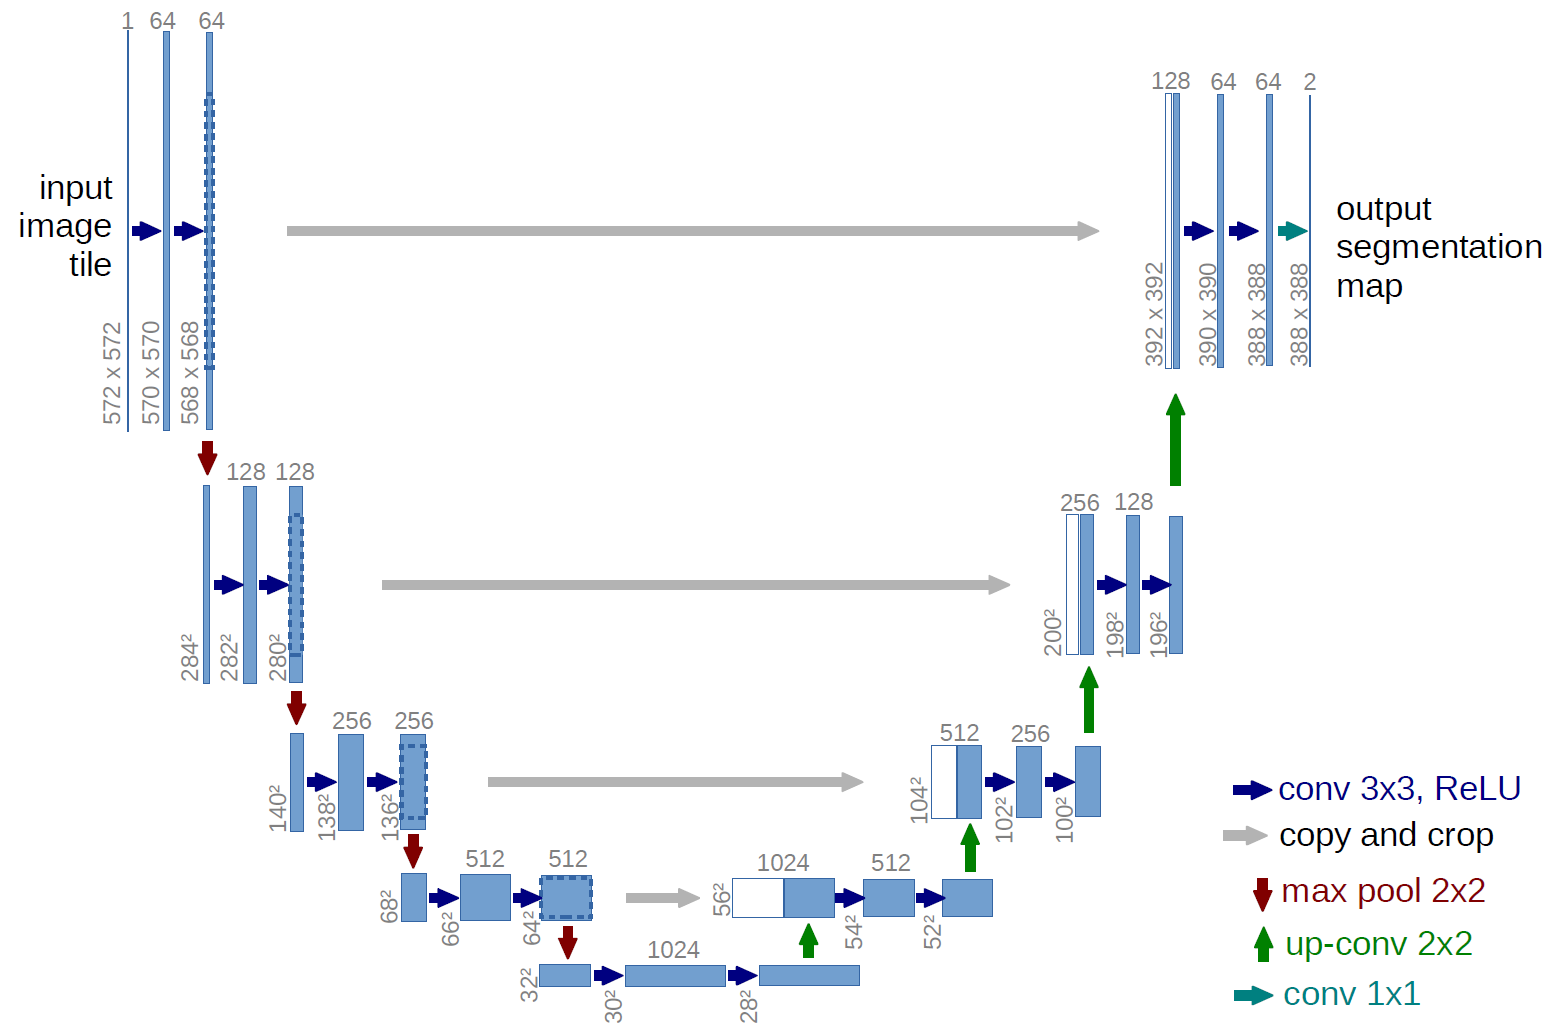

The main differences in our implementation are, that we do not use the same input / output size and we set at each convolution a zero padding border of size 1 (i.e. we pad the borders of the input), which not only yields different input / output sizes as in the picture, but also fixes one issue the original architecture add: For each expanding path the output image needed to be cropped to fit together into the decoder layer and the output of the model would not attain the same dimensions as the input. 
Otherwise, our implementation is the same, having two convolutional layers at each encoder / decoder layer and also performing max pooling at the end of each encoder layer and a transposed convolution at the end of each decoder layer (except the last one of course).

For the training we use the ADAM optimizer, which is a popular extension of stochastic gradient descent (SGD) utilizing additionally a momentum (the second moment of the gradient) and a variable learning rate for the parameters. 

We use the binary cross-entropy (BCE) loss as our loss function but extend our approach at a later run to test the performance improvement when using a so called soft dice loss (and an average of the BCE and the soft dice loss). We will explain the reasoning of using the dice loss later. 

We train the model for 100 epochs with a batch size of 4. Additionally we use early stopping, were we discontinue training if the validation loss does not improve over 11 epochs. Finally, we select the best model using the validation loss (and not just the model from the last epoch iteration). Let us first use just the default learning rate and see how we fare when ignoring our findings from EDA.

In [2]:
# Instantiate model
torch.manual_seed(42) # seed for reporducibility when using random weight initialization
model = UNet(256, 256).to(device)

# Set some parameters, instantiate the optimizer 
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.BCEWithLogitsLoss()
batch_size = 4
epochs_to_try = 100
patience = 11
modelname = ".\\models\\base_u_net" # Name of the saved model and the results.csv

# Create dataloaders from datasets
train_data_loader = DataLoader(
    rooftops_dataset(".\\data\\train",
                     transform=T.ToTensor()),
    shuffle=True,
    batch_size=batch_size
)
val_data_loader = DataLoader(
    rooftops_dataset(".\\data\\validation",
                     transform=T.ToTensor()),
    shuffle=False,
    batch_size=batch_size
)

dataloaders = {"train": train_data_loader,
               "validation": val_data_loader}

# Perform training
results = train_fun(model=model,
                    optimizer=optimizer,
                    data_loaders=dataloaders,
                    criterion=criterion,
                    device=device,
                    model_path=modelname,
                    epochs=epochs_to_try,
                    patience=patience)

Epoch: 5 | Avg. Train Loss:  0.385 | Avg. Val Loss:  0.386 | Learning Rate:  0.00100
Epoch: 10 | Avg. Train Loss:  0.351 | Avg. Val Loss:  0.348 | Learning Rate:  0.00100
Epoch: 15 | Avg. Train Loss:  0.303 | Avg. Val Loss:  0.324 | Learning Rate:  0.00100
Epoch: 20 | Avg. Train Loss:  0.294 | Avg. Val Loss:  0.312 | Learning Rate:  0.00100
Epoch: 25 | Avg. Train Loss:  0.292 | Avg. Val Loss:  0.312 | Learning Rate:  0.00100
Epoch: 30 | Avg. Train Loss:  0.271 | Avg. Val Loss:  0.284 | Learning Rate:  0.00100
Epoch: 35 | Avg. Train Loss:  0.283 | Avg. Val Loss:  0.298 | Learning Rate:  0.00100
Epoch: 40 | Avg. Train Loss:  0.275 | Avg. Val Loss:  0.312 | Learning Rate:  0.00100
Epoch: 45 | Avg. Train Loss:  0.265 | Avg. Val Loss:  0.293 | Learning Rate:  0.00100
Epoch: 50 | Avg. Train Loss:  0.277 | Avg. Val Loss:  0.299 | Learning Rate:  0.00100
Epoch: 55 | Avg. Train Loss:  0.239 | Avg. Val Loss:  0.261 | Learning Rate:  0.00100


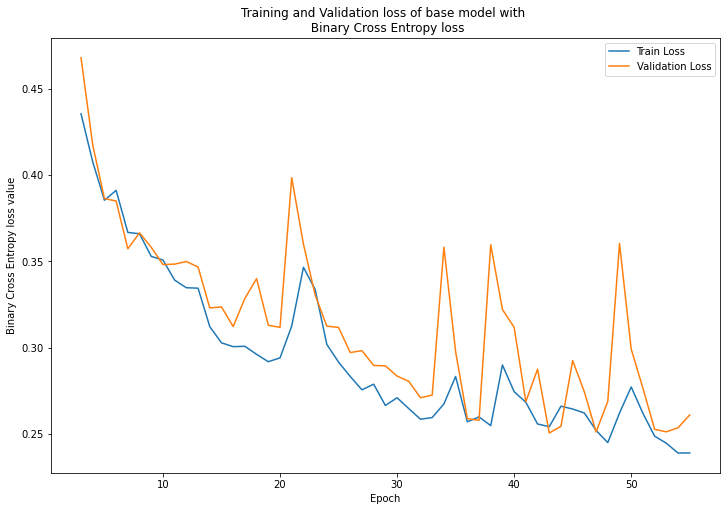

In [3]:
# Plot loss curves for train and validation set (excluding first 2 epochs to not mess up y-axis scaling)
results_path = modelname + "_results.csv"
plot_losses(results_path)

We see that training is ended prematurely by the early stopping criterion. Overall the first results look promising, as validation as well as train loss steadily decreases, albeit with significant spikes starting from epoch 20. Also our model does not seem to overfit (in the traditional sense), and the gap between validation and training error is not too large. Let us first check, if we can improve the performance by deploying a simple learning rate scheduler to reduce the amplitude of the spikes and hopefully, slightly increase the overall performance. We deploy an exponential lr scheduler, that reduces the learning rate with a multiplicative factor at each step. 

In [6]:
# Instantiate model
torch.manual_seed(42) # seed for reporducibility when using random weight initialization
model = UNet(256, 256).to(device)

# Set some parameters, instantiate the optimizer 
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
batch_size = 4
epochs_to_try = 100
patience = 11
modelname = ".\\models\\base_u_net_lr_sched" # Name of the saved model and the results.csv

# Perform training
results = train_fun(model=model,
                    optimizer=optimizer,
                    data_loaders=dataloaders,
                    criterion=criterion,
                    device=device,
                    model_path=modelname,
                    scheduler=scheduler,
                    epochs=epochs_to_try,
                    patience=patience)

Epoch: 5 | Avg. Train Loss:  0.386 | Avg. Val Loss:  0.391 | Learning Rate:  0.00090
Epoch: 10 | Avg. Train Loss:  0.347 | Avg. Val Loss:  0.363 | Learning Rate:  0.00082
Epoch: 15 | Avg. Train Loss:  0.302 | Avg. Val Loss:  0.325 | Learning Rate:  0.00074
Epoch: 20 | Avg. Train Loss:  0.282 | Avg. Val Loss:  0.318 | Learning Rate:  0.00067
Epoch: 25 | Avg. Train Loss:  0.273 | Avg. Val Loss:  0.290 | Learning Rate:  0.00060
Epoch: 30 | Avg. Train Loss:  0.227 | Avg. Val Loss:  0.308 | Learning Rate:  0.00055
Epoch: 35 | Avg. Train Loss:  0.231 | Avg. Val Loss:  0.243 | Learning Rate:  0.00049
Epoch: 40 | Avg. Train Loss:  0.234 | Avg. Val Loss:  0.259 | Learning Rate:  0.00045
Epoch: 45 | Avg. Train Loss:  0.215 | Avg. Val Loss:  0.246 | Learning Rate:  0.00040
Epoch: 50 | Avg. Train Loss:  0.214 | Avg. Val Loss:  0.247 | Learning Rate:  0.00036
Epoch: 55 | Avg. Train Loss:  0.178 | Avg. Val Loss:  0.243 | Learning Rate:  0.00033
Epoch: 60 | Avg. Train Loss:  0.178 | Avg. Val Loss:  0

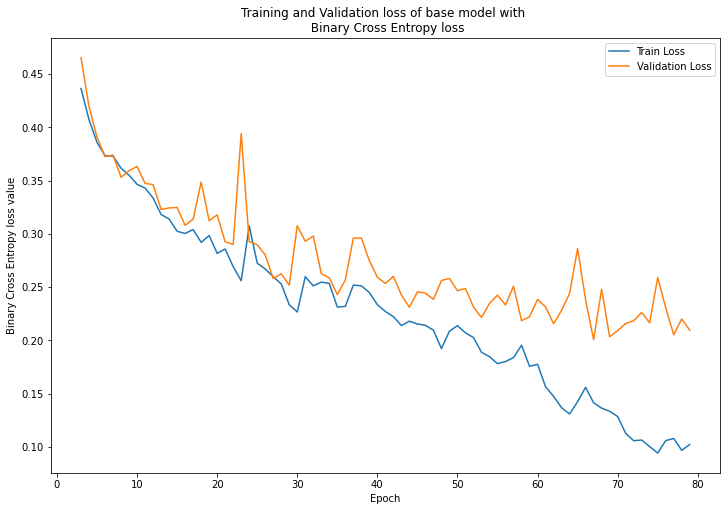

In [7]:
# Plot loss curves for train and validation set (excluding first 2 epochs to not mess up y-axis scaling)
results_path = modelname + "_results.csv"
plot_losses(results_path)

Splendid! We see that the overall amplitude of the spikes decreased by a large margin. However, we now have a different issue, namely overfitting. The train loss starts approaching 0, whereas the validation error plateaus. We thus need to combat overfitting.
Let us now adress this and the issues we found in 1. Firstly, let us add a small fraction of Gaussian noise in an additive manner to each picture during training, to reduce the risk of learning privacy related black boxes instead of actual rooftops. Additionally, let us incorporate some basic augmentation strategies such as rotation and horizontal, as well as vertical flipping of the image. 

In particular, we will scale the added noise by a small factor, perform -90, 90, and 180 degrees rotations randomly, and horizontal and vertical flipping of the image each of which with some probably during batching of the data (i.e. within the data set getitem method). We had to implement those transformations manually, since except the noise those transformations would need to be applied to the label as well, however, PyTorch random based transformations are not guaranteed to yield the exact same transformation with each call (random rotation). 

In [26]:
# Instantiate model
torch.manual_seed(42) # seed for reporducibility when using random weight initialization
model = UNet(256, 256).to(device)

# Set some parameters, instantiate the optimizer 
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
batch_size = 4
epochs_to_try = 100
patience = 11
modelname = ".\\models\\base_u_net_lr_augment" # Name of the saved model and the results.csv

# Augmentation params
augment_prob = {
        "p_hflip": 0.15,
        "p_vflip": 0.15,
        "p_rotation": 0.1,
        "p_noise" : 0.05
    }
augment_params = {
    "noise_mean": 0,
    "noise_std": 1,
    "noise_scale": 0.002,
    "rot_angles": [-90, 90, 180]
}
augment_dict = {"probs": augment_prob, "params": augment_params}

# Create dataloaders from datasets with augmentation
train_data_loader = DataLoader(
    rooftops_dataset(".\\data\\train",
                     transform=T.ToTensor(),
                     augment=True,
                     augment_dict=augment_dict),
    shuffle=True,
    batch_size=batch_size
)
val_data_loader = DataLoader(
    rooftops_dataset(".\\data\\validation",
                     transform=T.ToTensor(),
                     augment=True,
                     augment_dict=augment_dict),
    shuffle=False,
    batch_size=batch_size
)

dataloaders = {"train": train_data_loader,
               "validation": val_data_loader}

# Perform training
results = train_fun(model=model,
                    optimizer=optimizer,
                    data_loaders=dataloaders,
                    criterion=criterion,
                    device=device,
                    model_path=modelname,
                    scheduler=scheduler,
                    epochs=epochs_to_try,
                    patience=patience)

Epoch: 5 | Avg. Train Loss:  0.386 | Avg. Val Loss:  0.394 | Learning Rate:  0.00090
Epoch: 10 | Avg. Train Loss:  0.350 | Avg. Val Loss:  0.361 | Learning Rate:  0.00082
Epoch: 15 | Avg. Train Loss:  0.314 | Avg. Val Loss:  0.323 | Learning Rate:  0.00074
Epoch: 20 | Avg. Train Loss:  0.294 | Avg. Val Loss:  0.300 | Learning Rate:  0.00067
Epoch: 25 | Avg. Train Loss:  0.253 | Avg. Val Loss:  0.273 | Learning Rate:  0.00060
Epoch: 30 | Avg. Train Loss:  0.236 | Avg. Val Loss:  0.245 | Learning Rate:  0.00055
Epoch: 35 | Avg. Train Loss:  0.211 | Avg. Val Loss:  0.294 | Learning Rate:  0.00049
Epoch: 40 | Avg. Train Loss:  0.214 | Avg. Val Loss:  0.255 | Learning Rate:  0.00045
Epoch: 45 | Avg. Train Loss:  0.205 | Avg. Val Loss:  0.238 | Learning Rate:  0.00040
Epoch: 50 | Avg. Train Loss:  0.208 | Avg. Val Loss:  0.230 | Learning Rate:  0.00036
Epoch: 55 | Avg. Train Loss:  0.214 | Avg. Val Loss:  0.241 | Learning Rate:  0.00033
Epoch: 60 | Avg. Train Loss:  0.189 | Avg. Val Loss:  0

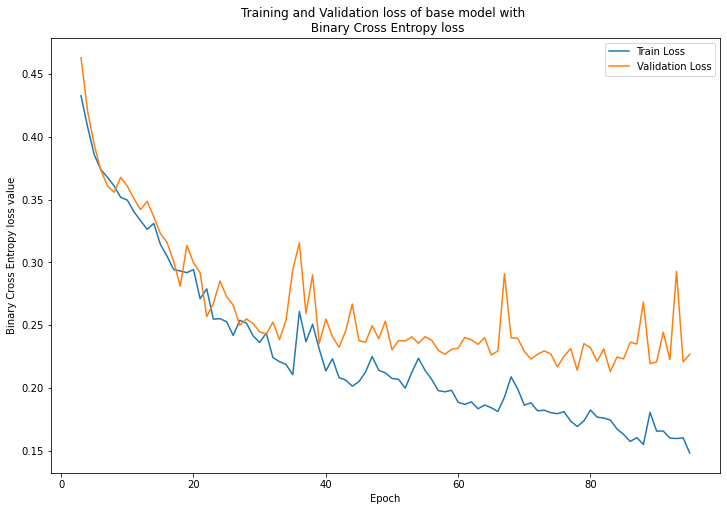

In [27]:
# Plot loss curves for train and validation set (excluding first 2 epochs to not mess up y-axis scaling)
results_path = modelname + "_results.csv"
plot_losses(results_path)